In [17]:
import torch
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import numpy as np

In [18]:
# Load the trained model 
model = torch.load('/models/run11/weights.pt')
# Set the model to evaluate mode
model.eval()

Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): ConvBNReLU(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=Fals

In [19]:
def count_parameters(model):
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        print(name,param)
        total_params+=param
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

encoder.features.0.0.weight 864
encoder.features.0.1.weight 32
encoder.features.0.1.bias 32
encoder.features.1.conv.0.0.weight 288
encoder.features.1.conv.0.1.weight 32
encoder.features.1.conv.0.1.bias 32
encoder.features.1.conv.1.weight 512
encoder.features.1.conv.2.weight 16
encoder.features.1.conv.2.bias 16
encoder.features.2.conv.0.0.weight 1536
encoder.features.2.conv.0.1.weight 96
encoder.features.2.conv.0.1.bias 96
encoder.features.2.conv.1.0.weight 864
encoder.features.2.conv.1.1.weight 96
encoder.features.2.conv.1.1.bias 96
encoder.features.2.conv.2.weight 2304
encoder.features.2.conv.3.weight 24
encoder.features.2.conv.3.bias 24
encoder.features.3.conv.0.0.weight 3456
encoder.features.3.conv.0.1.weight 144
encoder.features.3.conv.0.1.bias 144
encoder.features.3.conv.1.0.weight 1296
encoder.features.3.conv.1.1.weight 144
encoder.features.3.conv.1.1.bias 144
encoder.features.3.conv.2.weight 3456
encoder.features.3.conv.3.weight 24
encoder.features.3.conv.3.bias 24
encoder.featu

6628945

In [20]:
# Read the log file using pandas into a dataframe
df = pd.read_csv('/models/run11/log.csv')

### Training and testing loss, f1_score, auroc and IoU values for the model

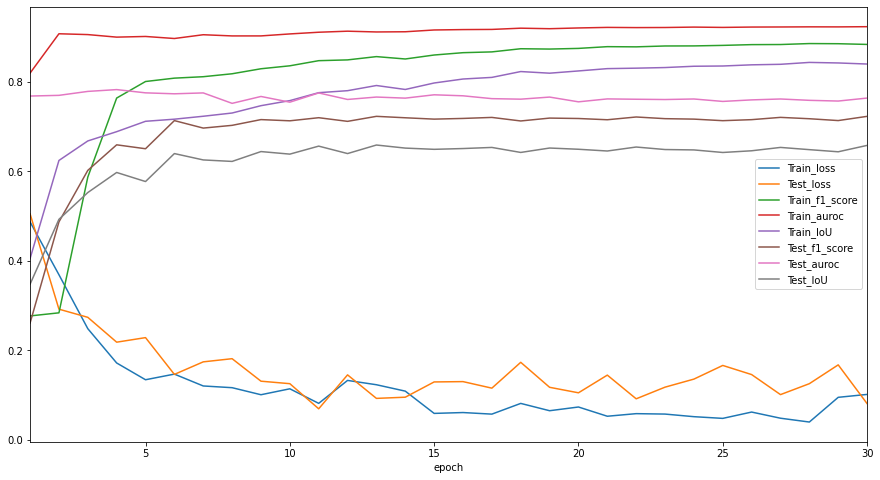

In [21]:
# Plot all the values with respect to the epochs
df.plot(x='epoch',figsize=(15,8));

In [22]:
print(df[['Train_IoU','Test_IoU']].max())

Train_IoU    0.843362
Test_IoU     0.658807
dtype: float64


### Sample Prediction

In [23]:
ino = 810
# Read  a sample image and mask from the data-set
img = cv2.imread(f'/models/train_data/Images/{ino:03d}.jpg')
img.shape


(320, 640, 3)

In [24]:
img = cv2.resize(img,None,fx=0.5,fy=0.5,interpolation=cv2.INTER_AREA).transpose(2,0,1).reshape(1,3,160,320)
mask = cv2.imread(f'/models/train_data/Masks/{ino:03d}_mask.png')
with torch.no_grad():
    a = model(torch.from_numpy(img).type(torch.cuda.FloatTensor)/255)

In [25]:
a.shape

torch.Size([1, 1, 160, 320])

(array([4.1932e+04, 9.3000e+01, 5.8000e+01, 4.8000e+01, 3.6000e+01,
        3.4000e+01, 4.5000e+01, 5.4000e+01, 8.6000e+01, 8.8140e+03]),
 array([9.2597667e-04, 1.0083040e-01, 2.0073482e-01, 3.0063924e-01,
        4.0054366e-01, 5.0044811e-01, 6.0035253e-01, 7.0025694e-01,
        8.0016136e-01, 9.0006578e-01, 9.9997020e-01], dtype=float32),
 <BarContainer object of 10 artists>)

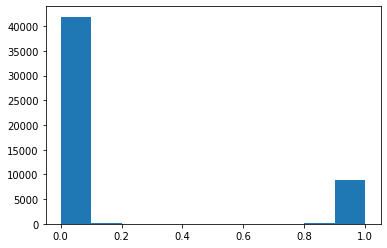

In [15]:
# Plot histogram of the prediction to find a suitable threshold. From the histogram a 0.1 looks like a good choice.
plt.hist(a.data.cpu().numpy().flatten())

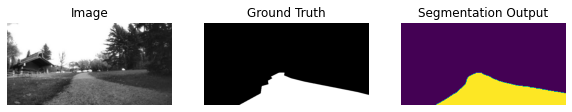

In [16]:
# Plot the input image, ground truth and the predicted output
plt.figure(figsize=(10,10));
plt.subplot(131);
plt.imshow(img[0,...].transpose(1,2,0));
plt.title('Image')
plt.axis('off');
plt.subplot(132);
plt.imshow(mask);
plt.title('Ground Truth')
plt.axis('off');
plt.subplot(133);
plt.imshow(a.cpu().detach().numpy()[0][0]>0.4);
plt.title('Segmentation Output')
plt.axis('off');
# plt.savefig('./SegmentationOutput.png',bbox_inches='tight')